In [1]:
load.resolver("imagej.public" at "http://maven.imagej.net/content/groups/public")
load.ivy("net.imagej" % "imagej" % "2.0.0-rc-44") // use % since %% adds scala version
load.ivy("de.christophkraemer" % "rhino-script-engine" % "1.1.0")  // since it's not in the classpath with notebooks per default
load.ivy("io.continuum.bokeh" %% "bokeh" % "0.6")

:: problems summary ::

:::: WARNINGS


	Host repo1.maven.org not found. url=https://repo1.maven.org/maven2/com/github/alexarchambault/jupyter/jupyter-scala-api_2.10.5/0.2.0-SNAPSHOT/maven-metadata.xml

	Host repo1.maven.org not found. url=https://repo1.maven.org/maven2/com/github/alexarchambault/jupyter/jupyter-scala-api_2.10.5/0.2.0-SNAPSHOT/jupyter-scala-api_2.10.5-0.2.0-SNAPSHOT.pom

	Host oss.sonatype.org not found. url=https://oss.sonatype.org/content/repositories/snapshots/com/github/alexarchambault/jupyter/jupyter-scala-api_2.10.5/0.2.0-SNAPSHOT/maven-metadata.xml

	Host oss.sonatype.org not found. url=https://oss.sonatype.org/content/repositories/snapshots/com/github/alexarchambault/jupyter/jupyter-scala-api_2.10.5/0.2.0-SNAPSHOT/jupyter-scala-api_2.10.5-0.2.0-SNAPSHOT.pom

	Host maven.imagej.net not found. url=http://maven.imagej.net/content/groups/public/com/github/alexarchambault/jupyter/jupyter-scala-api_2.10.5/0.2.0-SNAPSHOT/maven-metadata.xml

	Host maven.imagej.net not found. url=http://maven.imagej.net/cont

:::: ERRORS


	unknown resolver redefined-public

	unknown resolver redefined-public



  /Users/mader/.ivy2/cache/joda-time/joda-time/jars/joda-time-2.3.jar
It is likely they were updated, which may lead to instabilities in the REPL.


In [2]:
// make previewing a bit easier
implicit class previewDataset(curSet: net.imagej.Dataset)(implicit ij: net.imagej.ImageJ) {
    /** saves the file to a temporary directory, read it in again as a bytearray and feed it to the jupyter function **/
    def preview() = {
        val tFile = java.io.File.createTempFile("jupy",".jpg")
        ij.scifio().datasetIO().save(curSet,tFile.getPath())
        val imgFIS = new java.io.FileInputStream(tFile.getPath())
        val out = new Array[Byte](imgFIS.getChannel().size().toInt)
        imgFIS.read(out)
        display.jpg(out)
    }
}

defined class previewDataset

In [3]:
implicit val ij = new net.imagej.ImageJ()
// open as a typed image using datasetIO
import net.imglib2.`type`.numeric.integer.UnsignedByteType
val inputImg = "sample-data/starstack.tif"
val typedImage = ij.scifio().datasetIO().open(inputImg).typedImg(new UnsignedByteType())

[INFO] Reading IFDs
[INFO] Populating metadata
[INFO] Checking comment style
[WARNING] Expected positive value for PhysicalSizeX; got 0.0
[WARNING] Expected positive value for PhysicalSizeY; got 0.0
[WARNING] Expected positive value for PhysicalSizeX; got 0.0
[WARNING] Expected positive value for PhysicalSizeY; got 0.0


ij: net.imagej.ImageJ = net.imagej.ImageJ@2961ed93
import net.imglib2.`type`.numeric.integer.UnsignedByteType
inputImg: java.lang.String = "sample-data/starstack.tif"
typedImage: net.imagej.ImgPlus[net.imglib2.type.numeric.integer.UnsignedByteType] = io.scif.img.SCIFIOImgPlus@4595736b

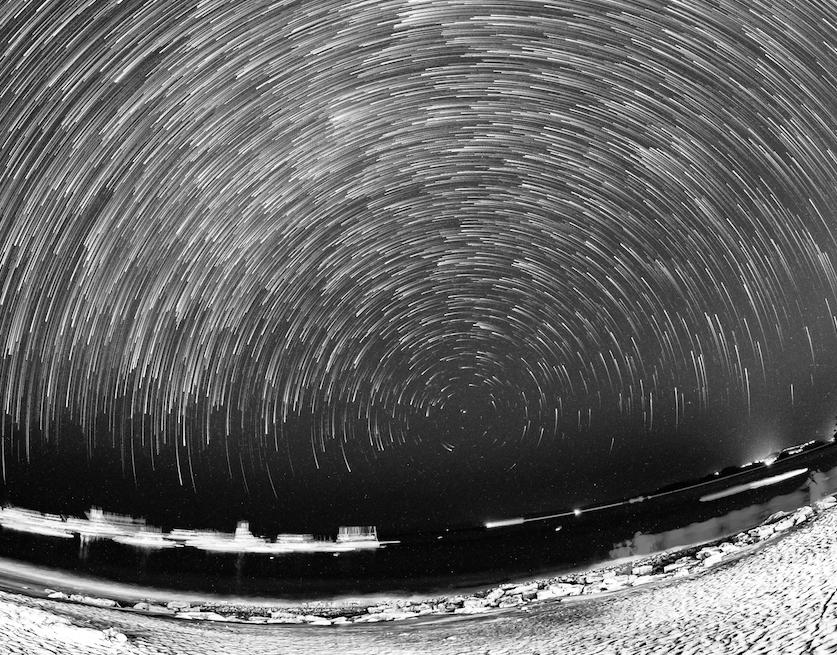

In [4]:
// preview the image
ij.dataset().create(typedImage).preview()

In [5]:
val histResults = ij.op().run("histogram",typedImage).asInstanceOf[net.imglib2.histogram.Histogram1d[UnsignedByteType]]


histResults: net.imglib2.histogram.Histogram1d[net.imglib2.type.numeric.integer.UnsignedByteType] = net.imglib2.histogram.Histogram1d@5b335489

In [9]:
/** a tool for plotting histograms using bokeh that automatically latches on **/
implicit class HistogramPlotter[T](histResults: net.imglib2.histogram.Histogram1d[T]) {
    import io.continuum.bokeh._
    def createHTML(log_x: Boolean = false, log_y: Boolean = false) = {
        val histArr = histResults.toLongArray.zipWithIndex.map{
        case (cnt,binId) => ((binId*1.0*(histResults.max-histResults.min)/histResults.size),cnt)
        }
        val x = histArr.map(_._1.toDouble)
        val y = histArr.map(_._2)

        val source = new ColumnDataSource()
            .addColumn('x, x)
            .addColumn('y, y)

        val xdr = new DataRange1d()
        val ydr = new DataRange1d()

        val line = new Line().x('x).y('y).line_color(Color.Blue)

        val renderer = new GlyphRenderer()
            .data_source(source)
            .glyph(line)

        val plot = new Plot().x_range(xdr).y_range(ydr)

        val xaxis = {if (log_x) new LogAxis() else new LinearAxis()}.plot(plot)
        val yaxis = {if (log_y) new LogAxis() else new LinearAxis()}.plot(plot)
        plot.below <<= (xaxis :: _)
        plot.left <<= (yaxis :: _)

        val pantool = new PanTool().plot(plot)
        val wheelzoomtool = new WheelZoomTool().plot(plot)

        plot.renderers := List(xaxis, yaxis, renderer)
        plot.tools := List(pantool, wheelzoomtool)

        val document = new Document(plot)
        val tFile = java.io.File.createTempFile("jupy",".html")
        val html = document.save(tFile)
        println(s"Wrote ${html.file}. Open ${html.url} in a web browser.")
        scala.io.Source.fromFile(tFile.getPath()).getLines().toList.mkString("\n")
    }
    def plot() = display.html(createHTML())
}

defined class HistogramPlotter

Wrote /var/folders/87/qdzwp8795sj37r777qjqyybm0000gn/T/jupy2341794124177186760.html. Open file:///var/folders/87/qdzwp8795sj37r777qjqyybm0000gn/T/jupy2341794124177186760.html in a web browser.


<!DOCTYPE html>
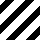
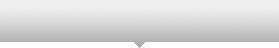
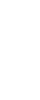
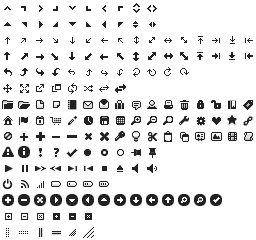
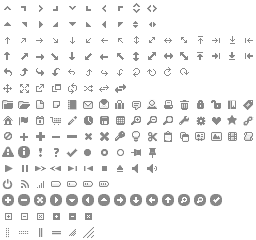
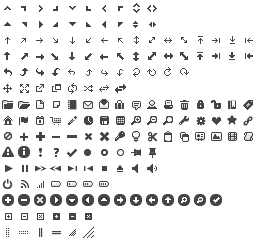
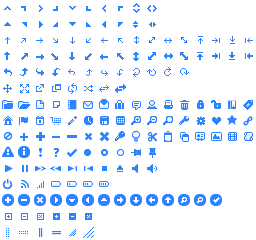
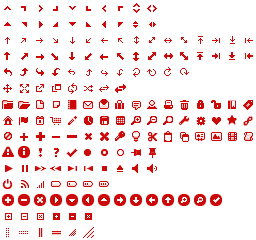
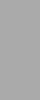
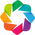
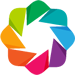
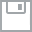
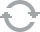
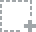
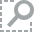
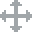
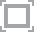
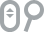

In [7]:
histResults.plot

Wrote /var/folders/87/qdzwp8795sj37r777qjqyybm0000gn/T/jupy2955050629296592763.html. Open file:///var/folders/87/qdzwp8795sj37r777qjqyybm0000gn/T/jupy2955050629296592763.html in a web browser.


<!DOCTYPE html>
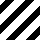
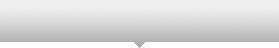
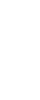
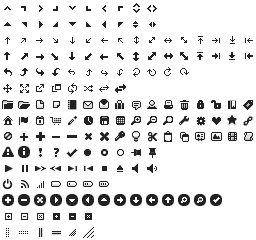
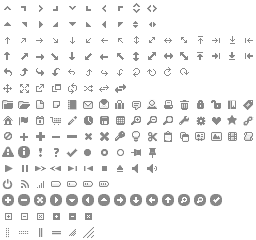
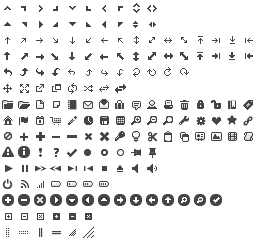
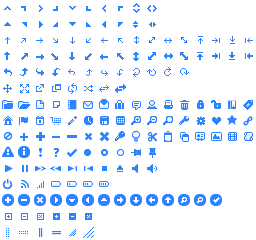
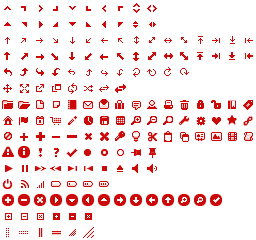
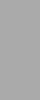
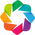
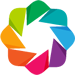
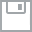
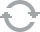
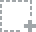
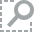
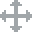
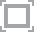
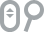

In [10]:
display.html(
    histResults.createHTML(log_y = true)
)